In [13]:
import pickle
import numpy as np
import scipy.stats as stats
import math
import json

In [14]:
model = "Qwen3-14B"

In [15]:
with open("/data/home/vkropoti/sql_data/mini-dev-index", "rb") as fp:   # Unpickling
    mini_dev_index = np.array(pickle.load(fp))
    
def load_json():
    with open('/home/vkropoti/vllm/dev.json', "r") as j:
        contents = json.loads(j.read())
    return contents

def load_split():
    data = load_json()
    query_level = []
    for k in range(len(data)):
        query_level.append(data[k]['difficulty'])
    return np.array(query_level)

In [16]:
split = load_split()

In [17]:
np.mean(split=='simple')

np.float64(0.6029986962190352)

In [18]:
np.mean(split=='moderate')

np.float64(0.30247718383311606)

In [19]:
np.mean(split=='challenging')

np.float64(0.09452411994784876)

In [20]:
def I_alpha(mean,n,std_dev,confidence = 0.95):
    # Критическое значение t для 95% ДИ и 49 степеней свободы
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin_of_error = t_value * (std_dev / math.sqrt(n))
    
    # Границы доверительного интервала
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    return ci_lower, ci_upper

In [21]:
def load_results(k,nobs,cot_type,think=False):
    # sql_results_Qwen3-8B-cot_all_new_think==False_nobs2-v0
    # with open(f"/data/home/vkropoti/sql_llm_answers/base_reasoning/sql_results_{model}-cot_{type_cot}_think=={use_think}-v{k}", "rb") as fp:
    with open(f"/data/home/vkropoti/sql_llm_answers/bird_dev/sql_results_Qwen3-14B-cot_{cot_type}_think=={think}_nobs{nobs}-v{k}", "rb") as fp:
        results = np.array(pickle.load(fp))
    return results

In [22]:
def load_executed(k,nobs,cot_type,think=False):
    # /data/home/vkropoti/sql_llm_answers/base_reasoning/sql_executed_{model}-cot_{type_cot}_think=={use_think}-v{version}
    with open(f"/data/home/vkropoti/sql_llm_answers/bird_dev/sql_executed_Qwen3-14B-cot_{cot_type}_think=={think}_nobs{nobs}-v{k}", "rb") as fp:
        executed = np.array(pickle.load(fp))
    return executed

In [41]:
def get_think_results(n,nobs=2,cot_type='all_new',think=False):
    
    arr_mean_scores = []
    arr_mean_executed = []
    d_split = {"simple":[], "moderate":[], "challenging":[]}
    for i in range(n):
        result, executed = load_results(i,nobs,cot_type,think), load_executed(i,nobs,cot_type,think)
        arr_mean_scores.append(np.mean(result))
        arr_mean_executed.append(np.mean(executed))
        d_split['simple'].append(np.mean(result[split=='simple']))
        d_split['moderate'].append(np.mean(result[split=='moderate']))
        d_split['challenging'].append(np.mean(result[split=='challenging']))
        
    if cot_type=='all_new':
        add = "данные о размышлениях + финальный ответ"
    elif cot_type=='think':
        add = "только данные о размышлениях"
    elif cot_type=='predict':
        add = "только данные о финальных ответах"

    ci_lower, ci_upper = I_alpha(np.mean(np.array(arr_mean_scores)),n,np.std(np.array(arr_mean_scores)))
    print(f"Модель основывает ответ по {nobs} выводам других моделей, которые включают {add}")
    print(f"Результаты получены прогоном {n} симуляций с разными seed")
    print(f"{model} DEV Финальный результат EX: {np.mean(np.array(arr_mean_scores)):.5f}, при std: {np.std(np.array(arr_mean_scores)):.4f}")
    print(f"95% доверительный интервал: ({ci_lower:.5f},{ci_upper:.5f})")
    for type_ in d_split:
        print(f"{type_}: {np.mean(np.array(d_split[type_])):.5f}")
    # print(f"{model} процент запросов, которые успешно выполнились DEV: {np.mean(np.array(arr_mean_executed)):.4f}, при std: {np.std(np.array(arr_mean_executed)):.4f}")
    return np.mean(np.array(arr_mean_scores))
    # print(f"{model} процент запросов, которые успешно выполнились Mini DEV: {np.mean(np.array(arr_mean_executed)):.4f}, при std: {np.std(np.array(arr_mean_executed)):.4f}")
    

## Использование reasoning+ответ

In [42]:
scores = []
for n in range(2,8):
    scores.append(get_think_results(20,nobs=n,cot_type='all_new'))
    print()

Модель основывает ответ по 2 выводам других моделей, которые включают данные о размышлениях + финальный ответ
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.57500, при std: 0.0036
95% доверительный интервал: (0.57332,0.57668)
simple: 0.64486
moderate: 0.48782
challenging: 0.40828

Модель основывает ответ по 3 выводам других моделей, которые включают данные о размышлениях + финальный ответ
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.57731, при std: 0.0038
95% доверительный интервал: (0.57555,0.57908)
simple: 0.64805
moderate: 0.49052
challenging: 0.40379

Модель основывает ответ по 4 выводам других моделей, которые включают данные о размышлениях + финальный ответ
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.57885, при std: 0.0041
95% доверительный интервал: (0.57693,0.58076)
simple: 0.64935
moderate: 0.49213
challenging: 0.40655

Моде

## Использование только ответ

In [43]:
scores_predict = []
for n in range(2,8):
    scores_predict.append(get_think_results(20,nobs=n,cot_type='predict'))
    print()

Модель основывает ответ по 2 выводам других моделей, которые включают только данные о финальных ответах
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.57846, при std: 0.0041
95% доверительный интервал: (0.57652,0.58039)
simple: 0.64611
moderate: 0.49213
challenging: 0.42310

Модель основывает ответ по 3 выводам других моделей, которые включают только данные о финальных ответах
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.57901, при std: 0.0047
95% доверительный интервал: (0.57681,0.58121)
simple: 0.64730
moderate: 0.49300
challenging: 0.41862

Модель основывает ответ по 4 выводам других моделей, которые включают только данные о финальных ответах
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.57898, при std: 0.0049
95% доверительный интервал: (0.57668,0.58127)
simple: 0.64724
moderate: 0.49526
challenging: 0.41138

Модель основывает отве

## Использование только размышлений

In [44]:
scores_think = []
for n in range(2,5):
    scores_think.append(get_think_results(20,nobs=n,cot_type='think'))
    print()

Модель основывает ответ по 2 выводам других моделей, которые включают только данные о размышлениях
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.57229, при std: 0.0047
95% доверительный интервал: (0.57010,0.57449)
simple: 0.64276
moderate: 0.48513
challenging: 0.40172

Модель основывает ответ по 3 выводам других моделей, которые включают только данные о размышлениях
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.57448, при std: 0.0033
95% доверительный интервал: (0.57293,0.57603)
simple: 0.64573
moderate: 0.48750
challenging: 0.39828

Модель основывает ответ по 4 выводам других моделей, которые включают только данные о размышлениях
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.57422, при std: 0.0039
95% доверительный интервал: (0.57241,0.57603)
simple: 0.64589
moderate: 0.48739
challenging: 0.39483



In [38]:
# get_think_results(20,nobs=6,cot_type='think')

In [39]:
# get_think_results(20,nobs=7,cot_type='think')

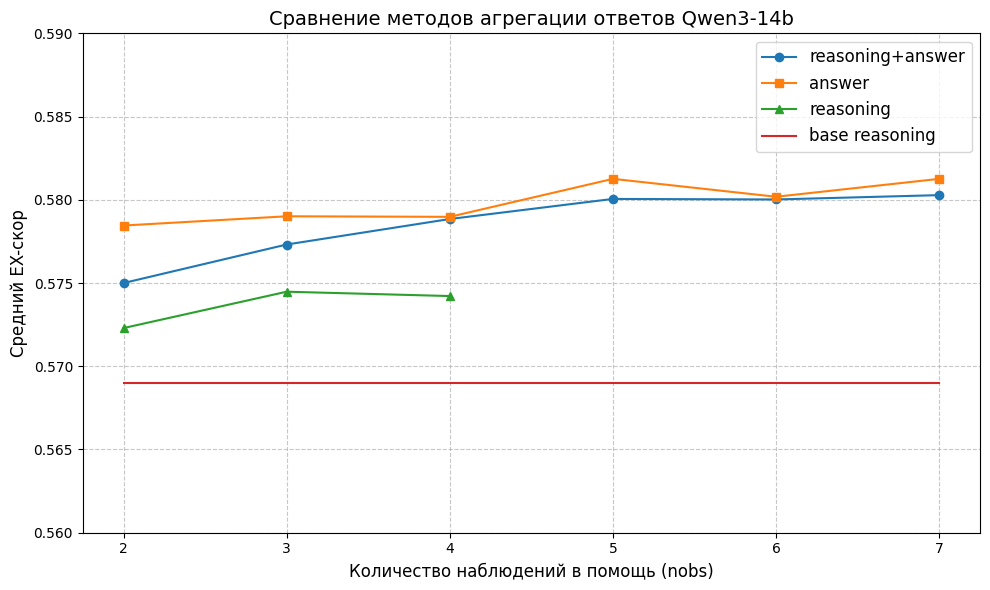

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Данные
nobs = [2, 3, 4, 5, 6, 7]
base_think = [0.569]*6
# Создание графика
plt.figure(figsize=(10, 6))
plt.plot(nobs, scores, marker='o', label='reasoning+answer', color='tab:blue')
plt.plot(nobs, scores_predict, marker='s', label='answer', color='tab:orange')
plt.plot(nobs[0:3], scores_think, marker='^', label='reasoning', color='tab:green')
plt.plot(nobs, base_think, label='base reasoning', color='tab:red')

# Настройки
plt.title('Сравнение методов агрегации ответов Qwen3-14b', fontsize=14)
plt.xlabel('Количество наблюдений в помощь (nobs)', fontsize=12)
plt.ylabel('Средний EX-скор', fontsize=12)
plt.xticks(nobs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.ylim(0.56, 0.59)  # Фиксируем диапазон для лучшего сравнения

# Отображение
plt.tight_layout()
plt.show()